# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](https://giving.virginia.edu/sites/default/files/2019-02/jgi-teaser-image.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points. To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Step 2: Process the  Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

--2022-11-17 21:01:54--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 74.125.130.95, 142.250.4.95, 74.125.24.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|74.125.130.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: â€˜dataset.zip?alt=mediaâ€™

dataset.zip?alt=med 100%[===================>] 378.77M  23.6MB/s    in 17s     

2022-11-17 21:02:12 (22.0 MB/s) - â€˜dataset.zip?alt=mediaâ€™ saved [397174132/397174132]



In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

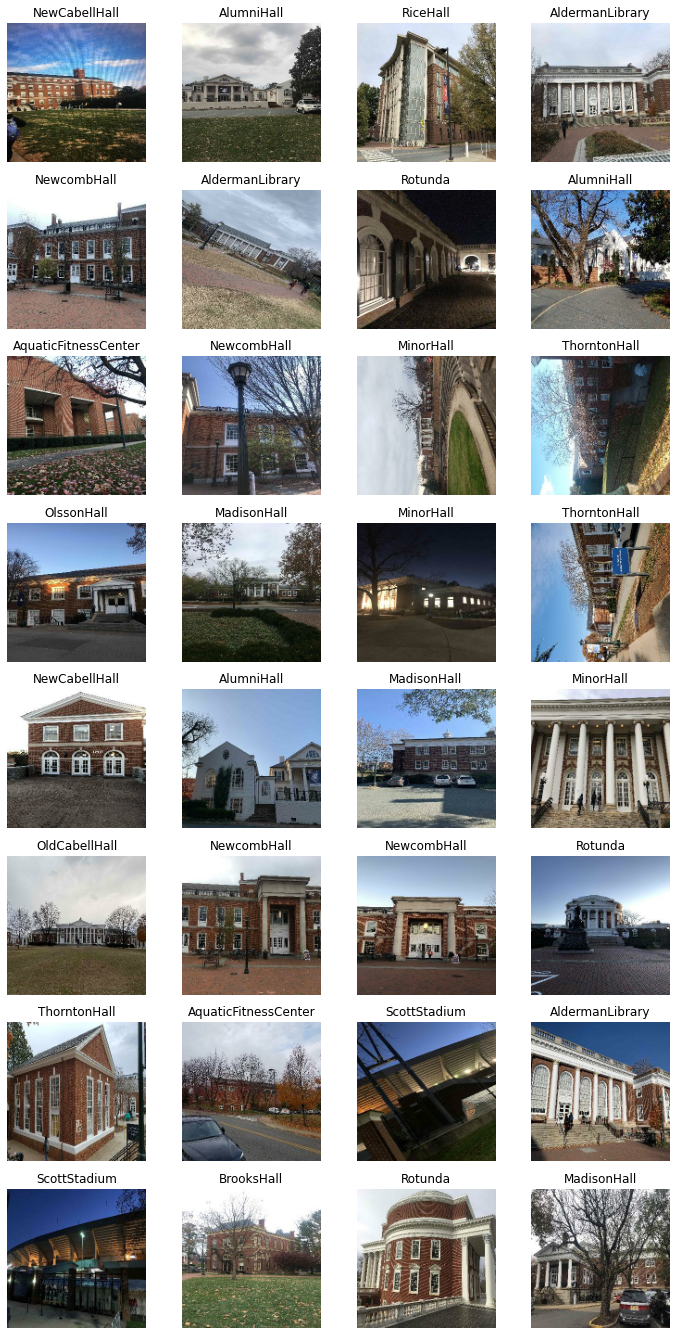

In [23]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# Step 3: Create your own CNN architecture
You must design your own architecture. To get started, you may get inspiration from one in CNN notebook  (i.e. use one similar to LeNet-5 or AlexNet). You will have to report the design of the architecture:

1.   How many layers does it have? 
2.   Why do you decide on a certain number nodes per layer? 
3.   Which activation functions do you choose? 
4.   How many parameters does it has in total?

Hint: use `myModel.summary()` to learn on the layers and parameters




After designing the model, you will need to train it. In order to train, you will need to pick a number of `epoch` (iteration), which `optimizer` to use (from  `keras.optimizers`), a `loss` function, and some `metrics`.

In [35]:
from keras.layers.attention.multi_head_attention import activation
from keras import layers
from keras.models import Sequential

# Your code here
myModel = Sequential()
myModel.add(layers.Dropout(.2))
for i in range(0,3):
  myModel.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
  myModel.add(layers.AveragePooling2D())
  myModel.add(layers.Dropout(.1))
myModel.add(layers.Flatten())
myModel.add(layers.Dropout(.2))
myModel.add(layers.Dense(120, activation='relu'))
myModel.add(layers.Dense(18, activation='softmax'))

from keras import optimizers, losses, metrics

myEpochs = 10 #TODO
myOptimizer = 'adam' #TODO
myLoss = losses.SparseCategoricalCrossentropy(from_logits=True) #TODO
myMetrics = ['accuracy'] #TODO keep in mind that this can be multiple metrics including at least the accuracy
myModel.compile(optimizer=myOptimizer,loss=myLoss,metrics=myMetrics)
myHistory = myModel.fit(train_ds,
            validation_data=validation_ds,
            epochs=myEpochs)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


358/358 [==============================] - 18s 47ms/step - loss: 3.4408 - accuracy: 0.1814 - val_loss: 2.4745 - val_accuracy: 0.2482
Epoch 2/10
358/358 [==============================] - 18s 47ms/step - loss: 2.2304 - accuracy: 0.3299 - val_loss: 3.0353 - val_accuracy: 0.2751
Epoch 3/10
358/358 [==============================] - 17s 47ms/step - loss: 1.7940 - accuracy: 0.4628 - val_loss: 2.2438 - val_accuracy: 0.3801
Epoch 4/10
358/358 [==============================] - 16s 45ms/step - loss: 1.4257 - accuracy: 0.5660 - val_loss: 1.8478 - val_accuracy: 0.4827
Epoch 5/10
358/358 [==============================] - 23s 64ms/step - loss: 1.1176 - accuracy: 0.6579 - val_loss: 2.0577 - val_accuracy: 0.4771
Epoch 6/10
358/358 [==============================] - 18s 50ms/step - loss: 0.8489 - accuracy: 0.7368 - val_loss: 1.7597 - val_accuracy: 0.5555
Epoch 7/10
358/358 [==============================] - 18s 50ms/step - loss: 0.6840 - accuracy: 0.7894 - val_loss: 2.0384 - val_accuracy: 0.5128
Epo

In [36]:
myModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_15 (Dropout)        (None, 150, 150, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 average_pooling2d_9 (Averag  (None, 74, 74, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout_16 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 average_pooling2d_10 (Avera  (None, 36, 36, 32)       0         
 gePooling2D)                                         

In [ ]:
# How many layers does it have?
"""
This model has 14 layers total (3 convolutional, 5 dropout, 3 average pooling, 2 dense, 1 flatten).
"""

# Why do you decide on a certain number nodes per layer?
"""
This was mostly determined through trial and error. I kept trying different combinations of nodes 
for each layer until I arrived at something that seemed to give reasonable results.
"""

# Which activation functions do you choose?
"""
Through my trial and error, I found that relu and softmax were the best.
"""

# How many parameters does it has in total?
"""
In total, it has 1,131,450 parameters!
"""

Next, you need to create (1) a plot of training and validation `loss` and (2) a plot of training and validation `accuracy`. These plots might give you some insights about your model performance and possibility of overfitting.

Report the performance of your architecture on the validation set in a `confusion matrix`. Make comments on the performance by answering the following questiosns:
- How well do you think your architecture is doing (overall accuracy)? 
- Where did it makes mistake most? 
- Which classes can be improved?

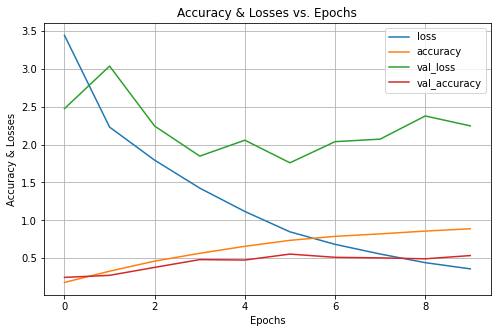

In [38]:
import pandas as pd

pd.DataFrame(myHistory.history).plot(figsize=(8, 5))
plt.title("Accuracy & Losses vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy & Losses")
plt.grid(True)
plt.show()

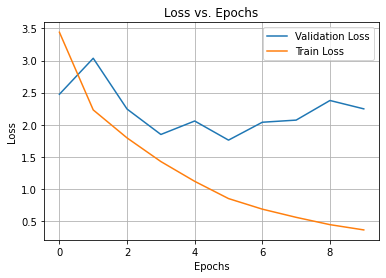

In [39]:
plt.plot(myHistory.history['val_loss'])
plt.plot(myHistory.history['loss'])
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Validation Loss","Train Loss"])
plt.grid(True)
plt.show()

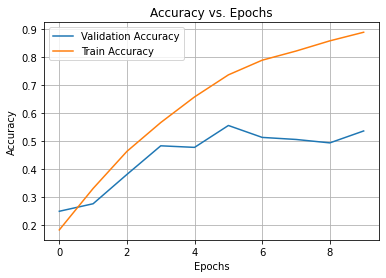

In [40]:
plt.plot(myHistory.history['val_accuracy'])
plt.plot(myHistory.history['accuracy'])
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Validation Accuracy","Train Accuracy"])
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix as c_matrix

# Your evaluation code here
y_actual = []
y_predicted = []
for x,y in validation_ds:
  y_actual = np.append(y_actual, y)
  y_predicted = np.append(y_predicted, np.argmax(myModel.predict(x), axis=-1))

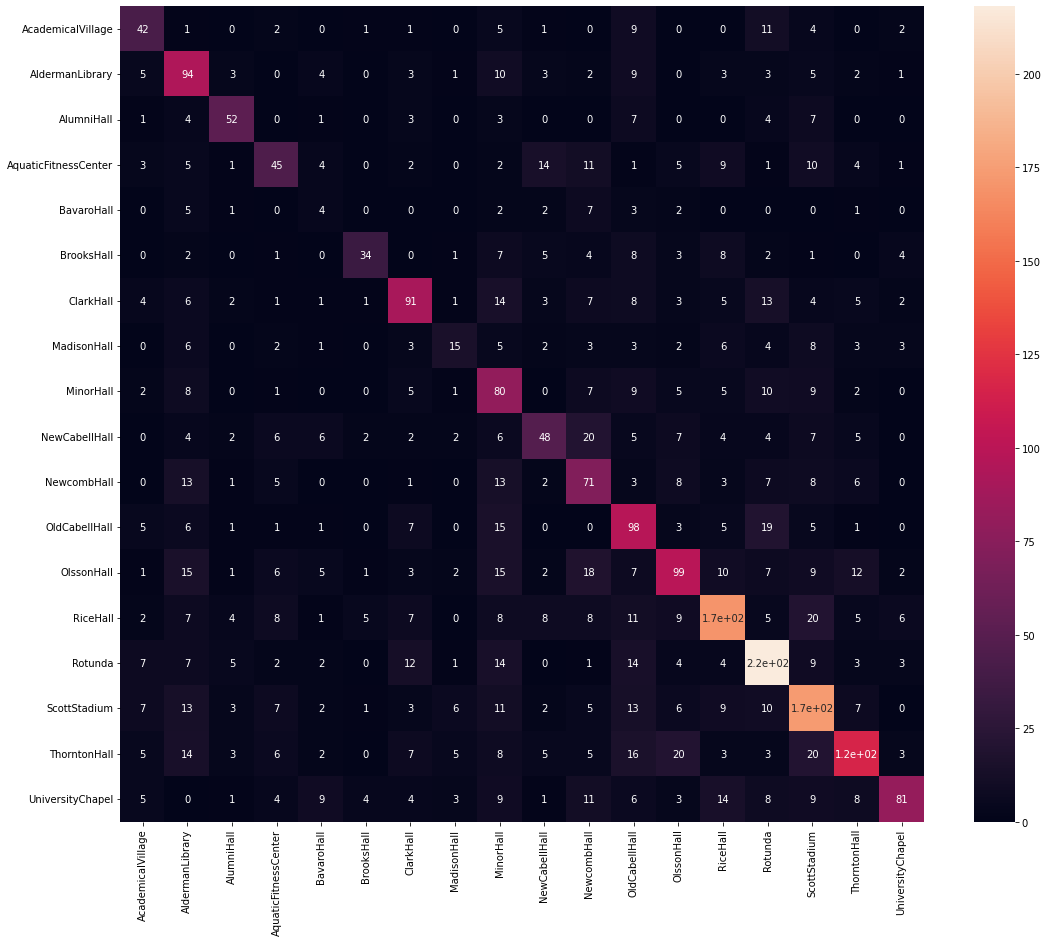

In [42]:
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

confusion = c_matrix(y_actual, y_predicted)
confusion_data = pd.DataFrame(confusion, index = class_names, columns = class_names)
plt.figure(figsize = (18,15))
sn.heatmap(confusion_data, annot=True)

In [ ]:
# How well do you think your architecture is doing (overall accuracy)?
"""
With a validation set accuracy of around 50%, my model is doing an OK job at predicting buildings. It 
does seem to be classifying some of the more "popular" buildings like Rice Hall, University Chapel, 
and Scott Stadium to name a few. It is still able to classify the lesser known buildings, but there is
a big drop off in accuracy.
"""

# Where did it makes mistake most?
"""
It struggles to classify Bavaro Hall. A possible explanation could be because there aren't as many
pictures of it in the dataset as there are other buildings.
"""

# Which classes can be improved?
"""
As I mentioned, Bavaro Hall is where it could improve the most, but perhaps the very popular buildings 
are overclassifying their data, which is something worth lookings into.
"""

# Step 4: Use a Pre-trained Network with Transfer Learning
Now that you have a your own custom model and some baseline performance, let's see if you can improve the performance using transfer learning and a pre-trained model. You may use any pre-trained model EXCEPT ones that already provided such as `Xception`, `MobileNet`, `EfficientNetB6`. Keep in mind that each pre-trained model may expect a different input shape, so adjust the size of your training images accordingly.

Make sure you report the design of this architecture by answer the same questions 1-4 in Step 3.

Hint: use `ImageNet` as weights when load the pre-train network, then add a `GlobalAveragePooling2D` and an output layer with `softmax` activation.



In [ ]:
# How many layers does it have?
"""
This model has 3 layers total (1 ResNet50, 1 GlobalAveragePooling2D layer, 1 Dense layer).
The ResNet50 layer has 172 total layers.
"""

# Why do you decide on a certain number nodes per layer?
"""
I mainly just followed the instructions for all of my layers, so I didn't have to try
over and over to see what an acceptable number of nodes was.
"""

# Which activation functions do you choose?
"""
For this, I only used softmax.
"""

# How many parameters does it has in total?
"""
In total, it has 23,624,594 parameters!
"""

In [45]:
# Your code here
from keras import layers
from keras.models import Sequential
from keras.applications.resnet import ResNet50

preTrainedModel = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))
preTrainedModel.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [54]:
fullModel = Sequential()
preTrainedModel.trainable = False
fullModel.add(preTrainedModel)
fullModel.add(layers.GlobalAveragePooling2D())
fullModel.add(layers.Dense(18,activation='softmax'))
fullModel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 18)                36882     
                                                                 
Total params: 23,624,594
Trainable params: 36,882
Non-trainable params: 23,587,712
_________________________________________________________________


Next, you will attempt to adapt this pre-trained model to your UVA Landmark dataset. It is recommended that you tried the two-phase training approach for your model:

1.   Phase 1: Freeze the pre-train weights and only train the top layer
2.   Phase 2: Train the entire network with much smaller learning rate (adapt the model to UVA data, but avoid destroying the transfered weights).



In [55]:
# Phase 1 code here
from keras import optimizers, losses, metrics

fullEpochs = 10
fullOptimizer = 'adam' #optimizers.RMSprop(learning_rate=0.005) 
fullLoss = losses.SparseCategoricalCrossentropy() 
fullMetrics = ["accuracy"] 
fullModel.compile(loss=fullLoss, optimizer=fullOptimizer, metrics=fullMetrics)
fullHistory = fullModel.fit(train_ds,
                              epochs=fullEpochs, 
                              validation_data=validation_ds)

Epoch 1/10
358/358 [==============================] - 31s 78ms/step - loss: 1.2754 - accuracy: 0.6386 - val_loss: 0.8903 - val_accuracy: 0.7441
Epoch 2/10
358/358 [==============================] - 27s 74ms/step - loss: 0.6803 - accuracy: 0.8148 - val_loss: 0.7293 - val_accuracy: 0.8050
Epoch 3/10
358/358 [==============================] - 26s 73ms/step - loss: 0.5179 - accuracy: 0.8625 - val_loss: 0.6543 - val_accuracy: 0.8159
Epoch 4/10
358/358 [==============================] - 27s 75ms/step - loss: 0.4125 - accuracy: 0.8943 - val_loss: 0.6298 - val_accuracy: 0.8239
Epoch 5/10
358/358 [==============================] - 27s 74ms/step - loss: 0.3378 - accuracy: 0.9148 - val_loss: 0.5858 - val_accuracy: 0.8365
Epoch 6/10
358/358 [==============================] - 32s 89ms/step - loss: 0.2912 - accuracy: 0.9282 - val_loss: 0.5641 - val_accuracy: 0.8386
Epoch 7/10
358/358 [==============================] - 27s 74ms/step - loss: 0.2453 - accuracy: 0.9419 - val_loss: 0.6113 - val_accuracy:

In [56]:
# Phase 2 code here
preTrainedModel.trainable = True

fullEpochs = 10
fullOptimizer = optimizers.RMSprop(learning_rate=0.000001) 
fullLoss = losses.SparseCategoricalCrossentropy() 
fullMetrics = ["accuracy"] 
fullModel.compile(loss=fullLoss, optimizer=fullOptimizer, metrics=fullMetrics)
fullHistory = fullModel.fit(train_ds,
                              epochs=fullEpochs, 
                              validation_data=validation_ds)

Epoch 1/10
358/358 [==============================] - 93s 221ms/step - loss: 1.3919 - accuracy: 0.6164 - val_loss: 1.2631 - val_accuracy: 0.6678
Epoch 2/10
358/358 [==============================] - 76s 212ms/step - loss: 0.9771 - accuracy: 0.7100 - val_loss: 1.0930 - val_accuracy: 0.7095
Epoch 3/10
358/358 [==============================] - 76s 213ms/step - loss: 0.7490 - accuracy: 0.7725 - val_loss: 0.9490 - val_accuracy: 0.7490
Epoch 4/10
358/358 [==============================] - 77s 215ms/step - loss: 0.5996 - accuracy: 0.8206 - val_loss: 0.8580 - val_accuracy: 0.7690
Epoch 5/10
358/358 [==============================] - 77s 216ms/step - loss: 0.4941 - accuracy: 0.8527 - val_loss: 0.7899 - val_accuracy: 0.7896
Epoch 6/10
358/358 [==============================] - 77s 213ms/step - loss: 0.4075 - accuracy: 0.8796 - val_loss: 0.7391 - val_accuracy: 0.8040
Epoch 7/10
358/358 [==============================] - 76s 212ms/step - loss: 0.3390 - accuracy: 0.9038 - val_loss: 0.6994 - val_ac

Repeat the same reporting of performance using the confusion matrix:
- Did this pre-trained network do better overall? 
- In which class it improve the accuracy from the above model? 
- Which class still has low performance? 

Typically, your network must have a reasonable performance of at least 84% overall accuracy to be considered successful in this domain. If your network achieves a accuracy of 94% or above on the validation set, you will also recieve a 10 bonus points, so keep trying!

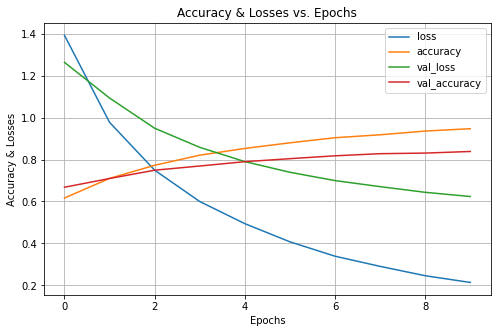

In [58]:
pd.DataFrame(fullHistory.history).plot(figsize=(8, 5))
plt.title("Accuracy & Losses vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy & Losses")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix as c_matrix

# Your evaluation code here
y_actual = []
y_predicted = []
for x,y in validation_ds:
  y_actual = np.append(y_actual, y)
  y_predicted = np.append(y_predicted, np.argmax(fullModel.predict(x), axis=-1))

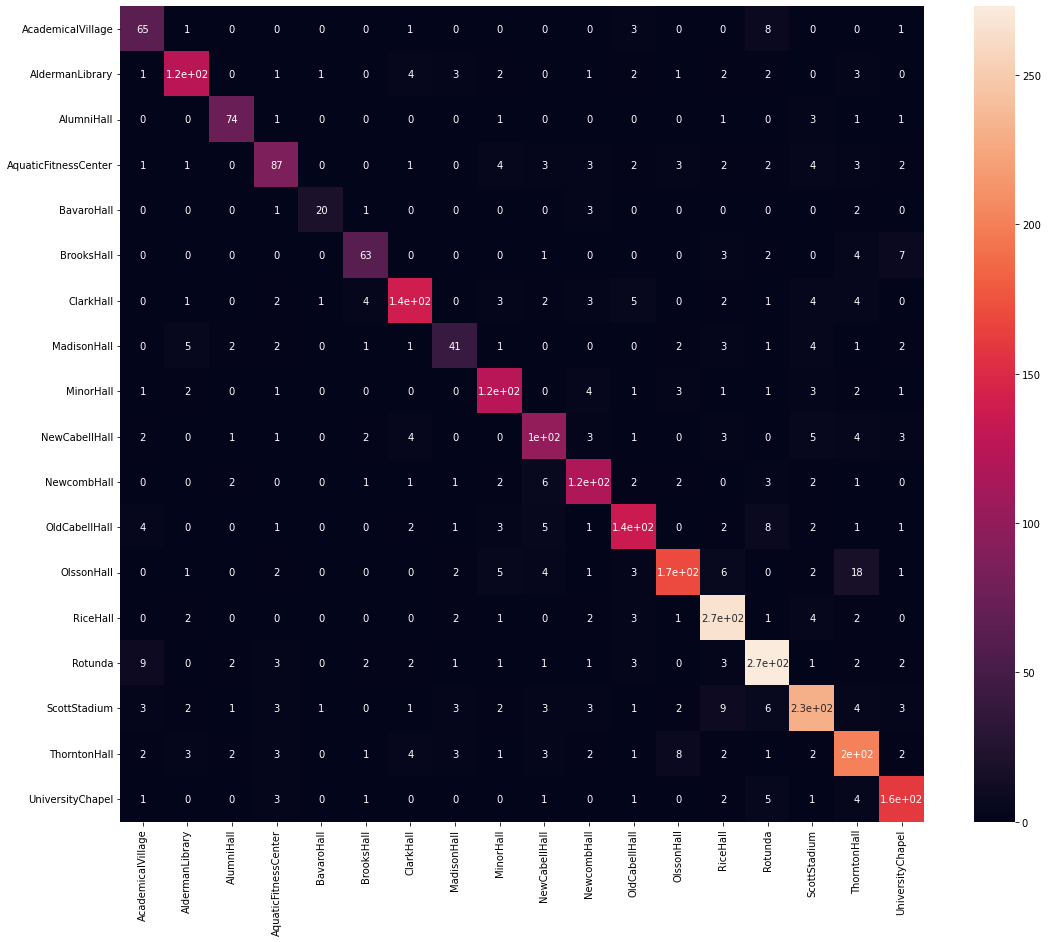

In [60]:
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

confusion = c_matrix(y_actual, y_predicted)
confusion_data = pd.DataFrame(confusion, index = class_names, columns = class_names)
plt.figure(figsize = (18,15))
sn.heatmap(confusion_data, annot=True)

In [ ]:
# Did this pre-trained network do better overall?
"""
I would certainly say so. This network as a validation set accuracy of around 80%
versus the 50% in my model.
"""

# In which class it improve the accuracy from the above model?
"""
It improved the accuracy of each class, especially Bavaro Hall. It also reduced the
amount of misclassifications, as you can see there aren't anywhere near as many
highlighted cells around the diagonal in this confusion matrix as there were in the
previous one.
"""

# Which class still has low performance?
"""
Bavaro Hall still has low performance, but since the model has much higher accuracy,
I would conclude that it is most likely because there aren't as many pictures of it
in the dataset.
"""

# Step 5: Reflection

Write at least a paragraph answering these prompts: How did your own network perform in comparison to the pre-trained one? What are the major differences between the architectures? Additionally, report on your experience implementing different models for this assignment (Was it hard/easy/fun?, from which part did you learn the most?)!

My model doesn't even compare to the pre-trained one. As I said before, the pre trained one has a validation set accuracy of 80% whereas my model has 50%. It also has much lower validation set loss, with the pre trained one coming in at .62% and my model coming in at 220%. Some of the biggest differences are the amount of convolutional layers the pre trained model has (53) versus my model (3). Mine also only had just over 1 million parameters, whereas the pre trained model had over 23 million. I found that implementing my architecture was far more obnoxious versus training the pre trained model. All that was required for the pre trained model was to follow the two phases and viola, we had a functional CNN model. To build my own architecture, I had to painstakingly try many different combinations of layers, parameters, settings, loss functions, epochs, and optimizers to try and find just one that worked! I found plotting the confusion matrices fun because it gave good intuition as to how good the models were, but not much else was very fun. I learned the most from building my own architecture, due to the fact that I spent 70% of my time on this assignment trying to get that to work. ðŸ¥–